### Ensemble models

Installing python libraries

In [1]:
!pip install matplotlib numpy pandas scikit-learn dask "dask[dataframe]"


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Importing python libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

Data preprocessing

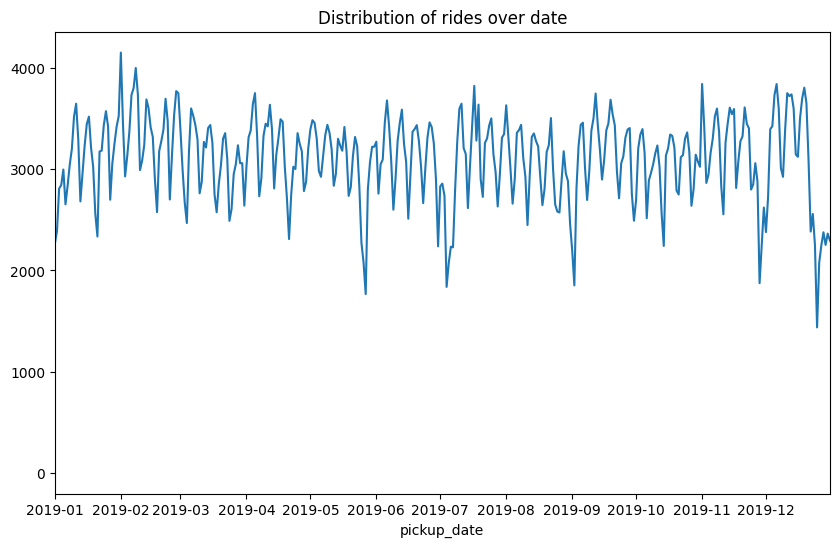

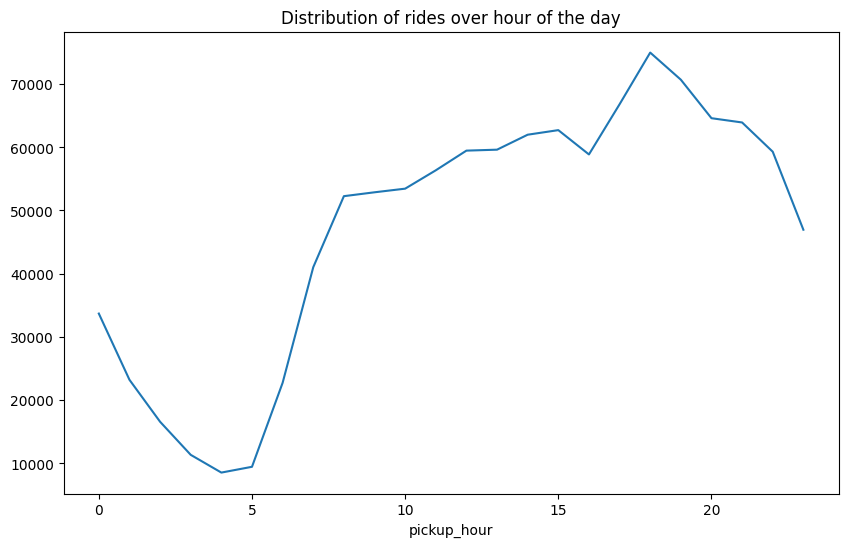

In [3]:
dataset = 'Datasets/2019new.csv'

if os.path.exists(dataset):
    # Load the CSV using dask for parallel processing
    df = dd.read_csv(dataset).compute()
    
    # If 'congestion_surcharge' column has NaNs, set them to 0
    df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)
    df = df.dropna()

    # Drop rows where 'trip_distance' is 0 and 'fare_amount' is <= 0
    df = df.drop(df[(df['trip_distance'] == 0)].index)
    df = df.drop(['total_amount'], axis=1)
    df = df.drop(['extra'], axis=1)
    df = df.drop(['mta_tax'], axis=1)
    df = df.drop(['tip_amount'], axis=1)
    df = df.drop(['tolls_amount'], axis=1)
    df = df.drop(['improvement_surcharge'], axis=1)
    df = df.drop(['congestion_surcharge'], axis=1)
    df = df.drop(['store_and_fwd_flag'], axis=1)
    df = df.drop(['payment_type'], axis=1)
    df = df[df['fare_amount'] > 0]
    df = df[df['fare_amount'] <= 50]

    # Convert 'tpep_pickup_datetime' to datetime and extract date and hour
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

    # Drop unneeded columns
    df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

    # Plotting distribution of rides over date
    plt.figure(figsize=(10, 6))
    df['pickup_date'].value_counts().sort_index().plot().set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-12-31'))
    plt.title('Distribution of rides over date')
    plt.show()

    # Plotting distribution of rides over hour of the day
    plt.figure(figsize=(10, 6))
    df['pickup_hour'].value_counts().sort_index().plot()
    plt.title('Distribution of rides over hour of the day')
    plt.show()
else:
    print("Dataset not found")


Including weather and holiday database and cleanup

In [6]:
weather = pd.read_csv('Datasets/weather.csv')

weather=weather.drop(columns=['tmax','tmin','departure','HDD','CDD'])
weather['date'] = pd.to_datetime(weather['date'])

holidays = pd.read_csv('Datasets/USHoliday.csv')

#maintain only if holiday is in 2019
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays=holidays[holidays['Date'].dt.year==2019]

#set precipitation to 0 if NaN and integer, new_snow, snow_depth
weather['precipitation'] = weather['precipitation'].replace(to_replace="T", value=0)
weather['new_snow'] = weather['new_snow'].replace(to_replace="T", value=0)
weather['snow_depth'] = weather['snow_depth'].replace(to_replace="T", value=0)

#set to float
weather['precipitation'] = weather['precipitation'].astype(float)
weather['new_snow'] = weather['new_snow'].astype(float)
weather['snow_depth'] = weather['snow_depth'].astype(float)

# Ensure the pickup_date column is in datetime64[ns] format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

new_df = pd.merge(df, weather, how='left', left_on='pickup_date', right_on='date')

new_df = new_df.drop(['date'], axis=1)
#add column 1 if week day, 2 if weekend, 3 if holiday
new_df['holiday'] = new_df['pickup_date'].isin(holidays['Date']).astype(int)
new_df['day_of_week'] = new_df['pickup_date'].dt.dayofweek
new_df['day_type'] = np.where(new_df['day_of_week'] < 5, 1, 2)
new_df.loc[new_df['holiday'] == 1, 'day_type'] = 3
new_df = new_df.drop(['pickup_date'], axis=1)
new_df = new_df.drop(['day_of_week'], axis=1)
new_df = new_df.drop(['holiday'], axis=1)
new_df = new_df.dropna()

/var/folders/n3/qm98005j2xn6lkrp94fvvbzm0000gn/T/ipykernel_84432/2287615902.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather['date'] = pd.to_datetime(weather['date'])


Merging the zones database and cleanup

In [7]:
zones = pd.read_csv('Datasets/taxi_zone_lookup.csv')
zones = zones.drop(['Borough'], axis=1)
zones = zones.drop(['Zone'], axis=1)

zones = zones[zones['service_zone'] != 'N/A']

# Replace 'EWR' with 'Airports' in the 'service_zone' column
zones['service_zone'] = zones['service_zone'].replace('EWR', 'Airports')

# Merge taxi_zone_lookup.csv with the new dataset on 'pulocationid' and 'dolocationid'
pulocation = new_df.merge(zones[['LocationID', 'service_zone']], left_on='pulocationid', right_on='LocationID', how='left')
dolocation = pulocation.merge(zones[['LocationID', 'service_zone']], left_on='dolocationid', right_on='LocationID', how='left', suffixes=('_pulocation', '_dolocation'))

# Create a new column 'zone_type' based on the conditions
def get_zone_type(row):
    service_zone_pulocation = row['service_zone_pulocation']
    service_zone_dolocation = row['service_zone_dolocation']

    if service_zone_pulocation == 'Airports' or service_zone_dolocation == 'Airports':
        return 1
    elif 'Boro Zone' in [service_zone_pulocation, service_zone_dolocation]:
        return 2
    elif 'Yellow Zone' in [service_zone_pulocation, service_zone_dolocation]:
        return 3
    else:
        return None

# Apply the zone_type function to the merged dataframe
dolocation['zone_type'] = dolocation.apply(get_zone_type, axis=1)

# Remove rows where 'zone_type' is None (rows that don't meet any of the conditions)
new_df = dolocation.dropna(subset=['zone_type'])

new_df = new_df.drop(['pulocationid'], axis=1)
new_df = new_df.drop(['dolocationid'], axis=1)
new_df = new_df.drop(['LocationID_pulocation'], axis=1)
new_df = new_df.drop(['service_zone_pulocation'], axis=1)
new_df = new_df.drop(['LocationID_dolocation'], axis=1)
new_df = new_df.drop(['service_zone_dolocation'], axis=1)
new_df = new_df.drop(['tavg'], axis=1)
new_df = new_df.drop(['precipitation'], axis=1)
new_df = new_df.drop(['new_snow'], axis=1)
new_df = new_df.drop(['snow_depth'], axis=1)

print(new_df.head(1))
print(new_df.shape)

   vendorid  passenger_count  trip_distance  ratecodeid  fare_amount  \
0       2.0              2.0           6.69         1.0         26.5   

   pickup_hour  day_type  zone_type  
0           19         2        2.0  
(1124454, 8)


Training

In [8]:
# Define train, test, validation sets
X = new_df.drop(['fare_amount'], axis=1)
y = new_df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Random Forest Regressor ensemble model

In [8]:
param_grid = {
    'n_estimators': [10, 30, 50],
    'max_features': [None, 5, 10],
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

Best Parameters: {'max_features': 5, 'n_estimators': 50}
Best R^2 Score: 0.913557405177575


In [9]:
bagging_rf = RandomForestRegressor(n_estimators=50, max_features=5, random_state=42)
bagging_rf.fit(X_train, y_train)

y_pred = bagging_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Squared Error: 4.719904650955639
Mean Absolute Error: 1.4495961942642237
R^2 Score: 0.9209192384781505


AdaBoost Regressor ensemble model

In [9]:
param_grid = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.01, 0.001],
}
grid_search = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 10}
Best R^2 Score: 0.8890718614728733


In [13]:
boosting_ada = AdaBoostRegressor(n_estimators=10, learning_rate=0.1, random_state=42)
boosting_ada.fit(X_train, y_train)

y_pred = boosting_ada.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Squared Error: 6.651689476218925
Mean Absolute Error: 1.8160368561093305
R^2 Score: 0.8885526916142763


Gradient Boosting Regressor ensemble model

In [11]:
param_grid = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.01, 0.001],
}
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best R^2 Score: 0.9218492909263071


In [14]:
boosting_grad = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
boosting_grad.fit(X_train, y_train)

y_pred = boosting_grad.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Squared Error: 4.534206325029837
Mean Absolute Error: 1.4345955652513367
R^2 Score: 0.9240305651072959


Stacking ensemble model

In [ ]:
# Define the base models
base_learners = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('en', ElasticNet(alpha=0.1, l1_ratio=0.5)),
    ('svr', SVR(kernel='rbf', C=1.0))
]
# ('rf', RandomForestRegressor(n_estimators=10, random_state=42)),
# ('gb', GradientBoostingRegressor(n_estimators=10, random_state=42)),
meta_model = LinearRegression()

stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)